## PHASE4 PROJECT
NAME : Hanifa Chepchirchir

COURSE : DSFT-12

FACILITATOR : Nikita Njoroge


### Business Understanding
 #### Objective:
SyriaTel is losing customers due to churn, which affects long-term revenue. The business wants to predict which customers are at risk of churning so they can proactively take steps (e.g., customer offers, improved support) to retain them.

##### Goals:
Identify patterns and features that are strong predictors of churn.

Develop a predictive model that outputs a binary classification (churn = 1, no churn = 0).

Provide actionable insights for SyriaTel's marketing and customer retention teams.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge,Lasso
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score,roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [3]:
df = pd.read_csv('datasets_2667_4430_bigml_59c28831336c6604c800002a.csv') 
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [6]:
df.drop(['phone number', 'area code', 'state'], axis=1, inplace=True, errors='ignore')


In [7]:
print(df.columns.tolist())


['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn']


In [8]:
# Convert yes/no to 1/0
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
# Convert target variable to binary
df['churn'] = df['churn'].astype(int)

In [11]:
# Define features and target
X = df.drop('churn', axis=1)
y = df['churn']


In [12]:

# Check class distribution
print("\nClass distribution:\n", y.value_counts(normalize=True))


Class distribution:
 churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64


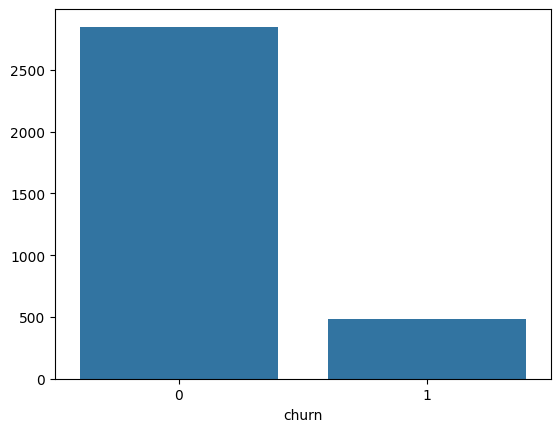

In [13]:
df['churn'].value_counts()
sns.barplot(x=df['churn'].value_counts().index, y=df['churn'].value_counts().values)
plt.show()

In [14]:
# Total minutes
df['total minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes']

# Total calls
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls']

# Total charge
df['total charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge']

# Average minutes per call
df['avg minutes per call'] = df['total minutes'] / df['total calls']

# Customer service calls per account length
df['service calls per length'] = df['customer service calls'] / df['account length']


In [15]:
# Check if the new features make sense
print(df[['total minutes', 'total day minutes', 'total eve minutes', 'total night minutes']].head())
print(df[['total charge', 'total day charge', 'total eve charge', 'total night charge']].head())

   total minutes  total day minutes  total eve minutes  total night minutes
0          707.2              265.1              197.4                244.7
1          611.5              161.6              195.5                254.4
2          527.2              243.4              121.2                162.6
3          558.2              299.4               61.9                196.9
4          501.9              166.7              148.3                186.9
   total charge  total day charge  total eve charge  total night charge
0         72.86             45.07             16.78               11.01
1         55.54             27.47             16.62               11.45
2         59.00             41.38             10.30                7.32
3         65.02             50.90              5.26                8.86
4         49.36             28.34             12.61                8.41


In [16]:

#  Drop original features that are now redundant
df.drop(['total day minutes', 'total eve minutes', 'total night minutes',
         'total day calls', 'total eve calls', 'total night calls',
         'total day charge', 'total eve charge', 'total night charge'], 
        axis=1, inplace=True)


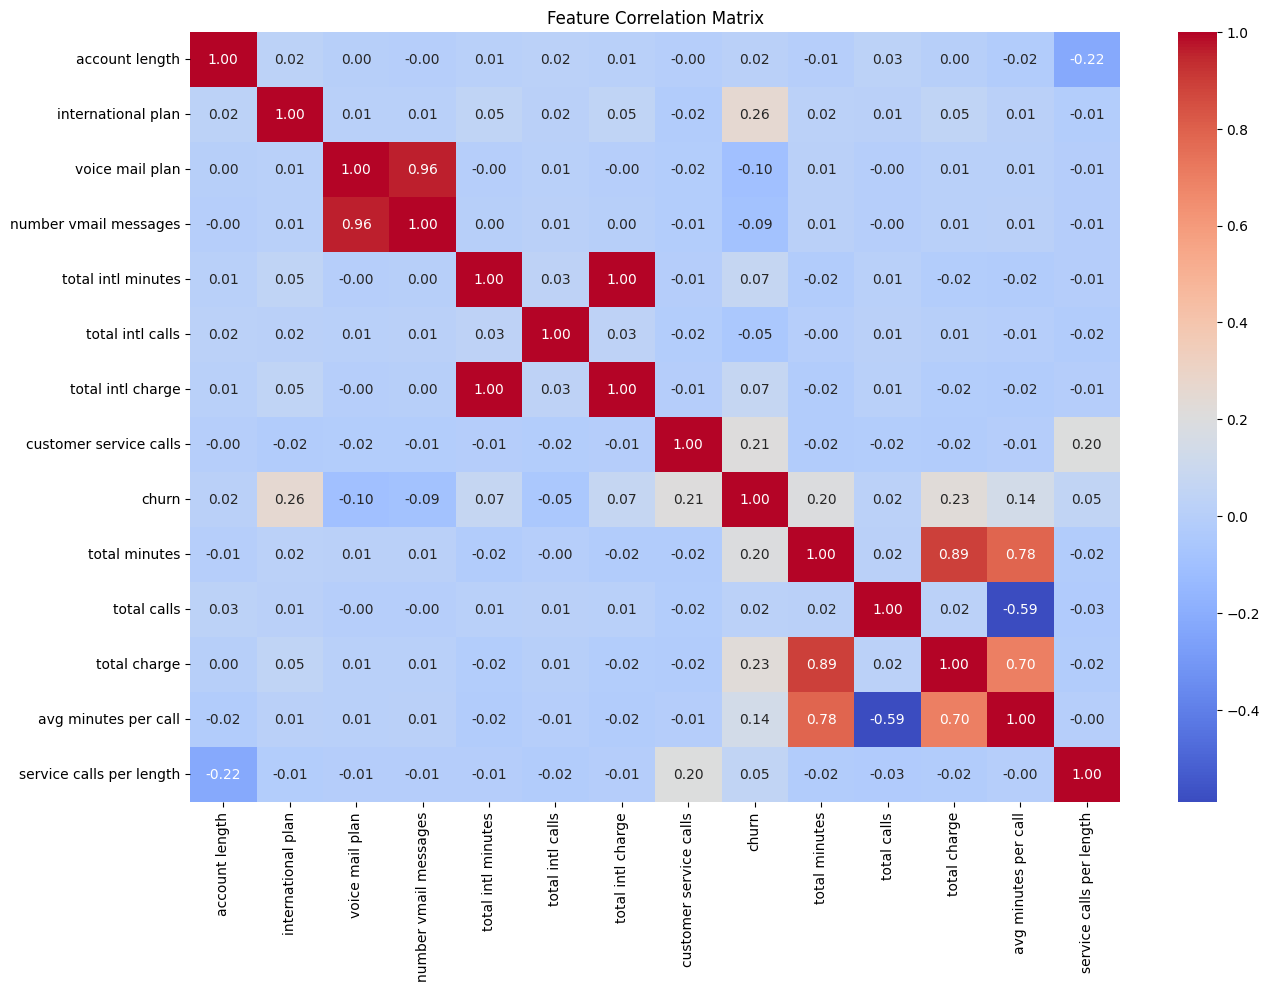

In [17]:
# Check correlation matrix
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


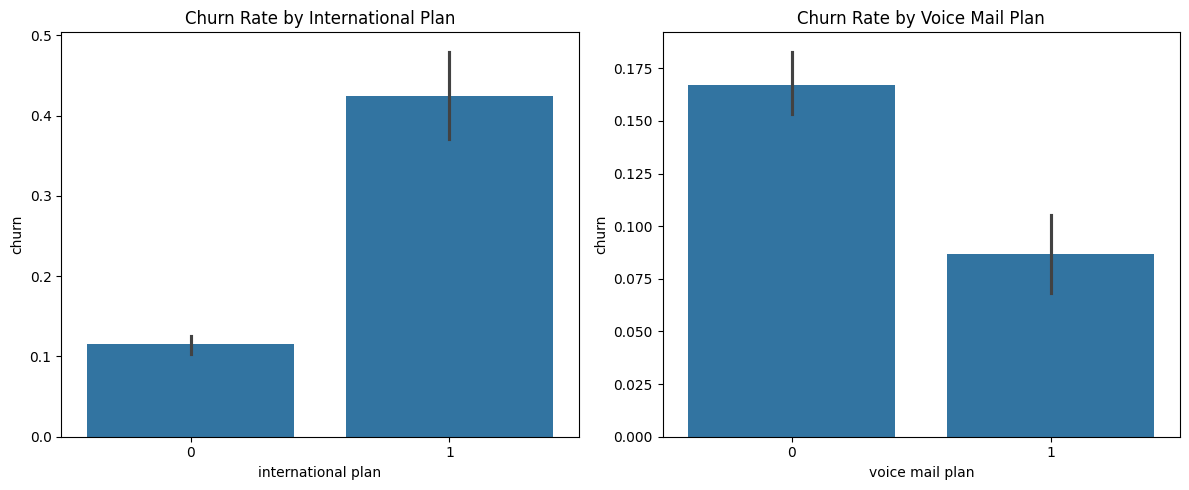

In [18]:
# Plot churn rate by international plan and voice mail plan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x='international plan', y='churn', data=df, ax=axes[0])
axes[0].set_title("Churn Rate by International Plan")
sns.barplot(x='voice mail plan', y='churn', data=df, ax=axes[1])
axes[1].set_title("Churn Rate by Voice Mail Plan")
plt.tight_layout()
plt.show()


In [19]:
y = df["churn"].value_counts()
print(f"Churn Data :\n{y}\n")

# save all the rows where churn is True
y_True = df["churn"][df["churn"] == True]
print(y_True)

print ("\nChurn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Data :
churn
0    2850
1     483
Name: count, dtype: int64

10      1
15      1
21      1
33      1
41      1
       ..
3301    1
3304    1
3320    1
3322    1
3323    1
Name: churn, Length: 483, dtype: int64

Churn Percentage = 14.491449144914492


In [20]:
print(df.columns.tolist())


['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn', 'total minutes', 'total calls', 'total charge', 'avg minutes per call', 'service calls per length']


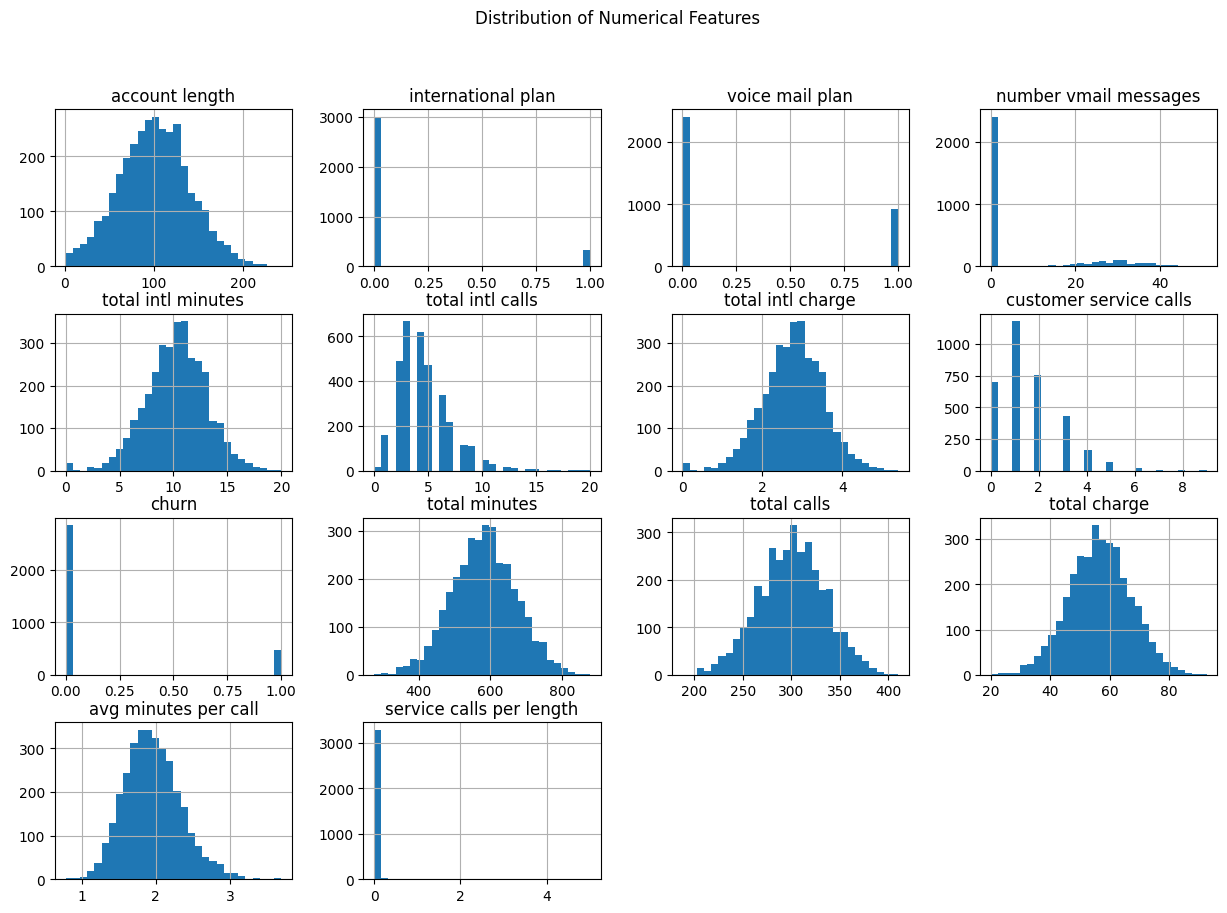

In [31]:
# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

In [21]:

X = df.drop(columns="churn",axis=1)
y = df["churn"]

In [22]:
feature_columns = df.drop(columns=['churn']).columns
X = df[feature_columns]
y = df['churn']


In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Scale the X values using MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create DataFrame for scaled training data
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_df
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled_df

,account length,international plan,voice mail plan,number vmail messages,total intl minutes,total intl calls,total intl charge,customer service calls,total minutes,total calls,total charge,avg minutes per call,service calls per length
438,0.311486,-0.326624,-0.611162,-0.584936,1.166657,-0.593980,1.172620,-0.428293,1.050788,0.633353,0.609246,0.362556,-0.139196
2674,-0.852632,-0.326624,-0.611162,-0.584936,0.916336,0.634849,0.920971,-1.175564,-0.735656,2.394122,-1.064921,-1.607964,-0.221276
1345,-0.068118,-0.326624,-0.611162,-0.584936,-1.229270,-1.413199,-1.224664,1.813519,-2.835648,-2.418647,-3.406454,-1.211110,0.157299
1957,1.171920,-0.326624,-0.611162,-0.584936,-0.013427,-1.003589,-0.019400,-0.428293,-0.086243,-0.511147,0.378161,0.175119,-0.158180
2148,-0.118732,-0.326624,-0.611162,-0.584936,-0.084947,1.044458,-0.085623,-0.428293,0.173746,-1.010032,-0.267151,0.746545,-0.124661
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,1.424989,-0.326624,-0.611162,-0.584936,-0.621349,0.225239,-0.615410,0.318978,0.149197,-1.127416,0.171048,0.814567,-0.103122
2763,0.387406,-0.326624,1.636228,0.807551,-0.728629,-1.003589,-0.734612,1.066249,-0.524764,1.102891,-0.548096,-0.998708,0.018597
3069,1.197227,-0.326624,1.636228,1.320572,-0.120707,-0.593980,-0.125357,-0.428293,-0.483478,0.163814,-0.592204,-0.532004,-0.158607
1468,-0.650176,-0.326624,1.636228,1.393861,-2.159033,1.044458,-2.165035,1.066249,-0.693254,1.249622,-0.988213,-1.175244,0.149728


In [25]:

# Use SMOTE to oversample and solve the imbalance

smt = SMOTE()
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_df,y_train)

In [29]:
# Add constant
X_train_const = sm.add_constant(X_train_df)

# Fit Multinomial Logistic Regression
model = sm.MNLogit(y_train, X_train_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.323133
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  churn   No. Observations:                 2666
Model:                        MNLogit   Df Residuals:                     2652
Method:                           MLE   Df Model:                           13
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.2136
Time:                        18:10:11   Log-Likelihood:                -861.47
converged:                       True   LL-Null:                       -1095.4
Covariance Type:            nonrobust   LLR p-value:                 9.564e-92
                 churn=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.3114      0.080    -28.904      0.000      -2.468

In [ ]:

# predictions
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_class):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_class):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))


Accuracy: 0.8471
Precision: 0.4000
Recall: 0.0198
F1 Score: 0.0377

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92       566
           1       0.40      0.02      0.04       101

    accuracy                           0.85       667
   macro avg       0.63      0.51      0.48       667
weighted avg       0.78      0.85      0.78       667



In [ ]:

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:

# Evaluate
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       566
           1       0.39      0.78      0.52       101

    accuracy                           0.78       667
   macro avg       0.67      0.78      0.69       667
weighted avg       0.87      0.78      0.81       667



In [ ]:

# Instantiate the model
model = Ridge(alpha=100,solver="sag", random_state=1)

# Fit the model on the scaled training data
model.fit(X_train_scaled, y_train)


Ridge(alpha=100, random_state=1, solver='sag')

In [ ]:

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:

train_rmse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"""
RMSE
Train: {train_rmse} \t Test: {test_rmse}

R-squared
Train: {train_r2} \t Test: {test_r2}
""")


RMSE
Train: 0.3172984230863006 	 Test: 0.3253033906288639

R-squared
Train: 0.1798436435405707 	 Test: 0.17644796863587242



In [ ]:
# Object creation, fitting the data & getting predictions
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_over,y_train_over)
y_pred_dt = decision_tree.predict(X_test)

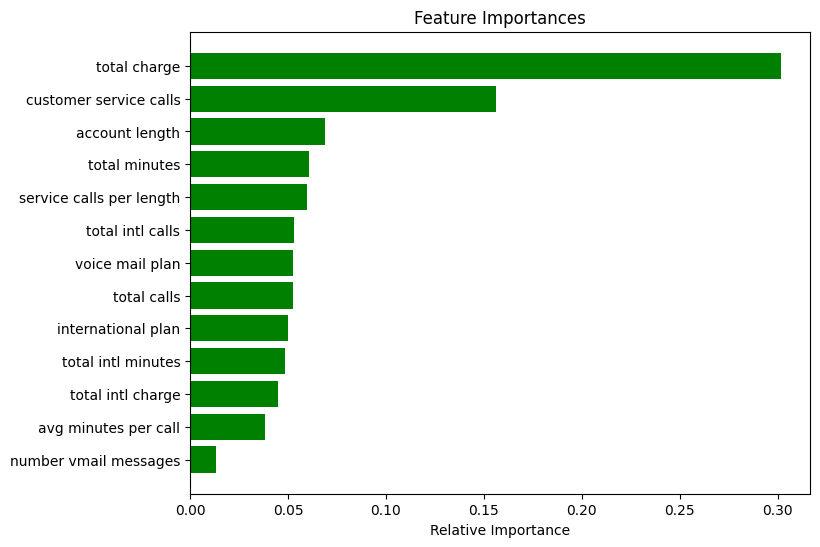

In [ ]:
feature_names = list(X_train_over.columns)
importances = decision_tree.feature_importances_[0:15]
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.87706
F1 score for testing set:  0.68462
Recall score for testing set:  0.88119
Precision score for testing set:  0.55975


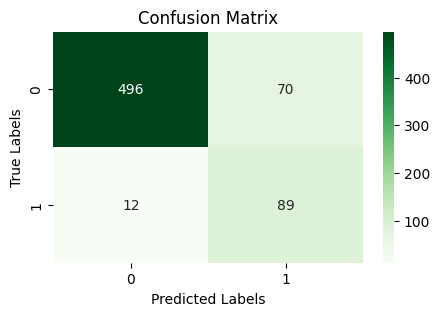

In [ ]:
print("**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_dt),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_dt),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_dt),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_dt),5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_dt, annot=True, cmap='Greens', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();